This is a demo analysis of a dataset with complex structure.

In [1]:
import scanpy as sc
from scperturb import edist, pairwise_pca_distances, etest#equal_subsampling
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import numpy as np
import pandas as pd 
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests


#from sklearn.metrics import pairwise_distances
#from statsmodels.stats.multitest import multipletests

from scipy.stats import zscore
from scipy.cluster.hierarchy import distance, linkage, dendrogram

In [ ]:

def cluster_matrix(matrix, how='row', return_order=False, method='centroid'):
    '''
    Hierarchical clustering of a matrix/dataframe. `how` can be 'col', 'row' or 'both' (default: 'row').
    '''
    if how not in ['col', 'row', 'both']:
        raise ValueError('Value for "how" must be row or col.')
    if how!='both':
        M = matrix if how=='row' else matrix.T
        dist = distance.pdist(M)
        link = linkage(dist, method=method)
        dend = dendrogram(link, no_plot=True)
        order = np.array(dend['leaves'], dtype=int)
        if return_order:
            return order
        elif isinstance(matrix, pd.DataFrame):
            return matrix.iloc[order] if how=='row' else matrix.iloc[:, order]
        else:
            return matrix[order] if how=='row' else matrix[:, order]
    else:
        if return_order:
            warn('Returning order when clustering both row and col is not supported.')
        matrix_ = cluster_matrix(matrix, how='row', return_order=False, method=method)
        return cluster_matrix(matrix_, how='col', return_order=False, method=method)

In [ ]:
adata  = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/GehringPachter2019/GehringPachter2019.h5ad")

In [ ]:
# Add a numerical index to the first perturbation for uniform access
# we're 1-indexing because I'm an R girl at heart 

adata.obs['perturbation_1'] = adata.obs['perturbation']
adata.obs['dose_value_1'] = adata.obs['dose_value']

In [ ]:
# create a new, joint perturbation column where each combo of perturbations is 
# identified by a unique string

adata.obs['perturbation']='p1_' + adata.obs['dose_value_1'].astype('str') +\
    '_p2_'+adata.obs['dose_value_2'].astype('str')  +\
    '_p3_'+adata.obs['dose_value_3'].astype('str') +\
    '_p4_'+adata.obs['dose_value_4'].astype('str')

In [ ]:
adata.obs['perturbation']

In [9]:
# basic filtering and pre-processing 

adata.layers['counts'] = adata.X.copy()

# basic qc and pp
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.normalize_per_cell(adata)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.log1p(adata)
sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

n_var_max = 2000  # max total features to select
sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata)

adata.uns['processed'] = True

/Users/tessa/miniforge3/envs/pertpy5/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
# save for later
adata.write("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/GehringPachter2019/GehringPachter2019_processed.h5ad")

In [2]:
# import processed adata
adata = sc.read_h5ad("/Users/tessa/Dropbox (HMS)/perturb_resource_tessa/GehringPachter2019/GehringPachter2019_processed.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 20382 × 11781
    obs: 'batch', 'disease', 'cancer', 'tissue_type', 'celltype', 'perturbation', 'perturbation_2', 'perturbation_3', 'perturbation_4', 'dose_unit', 'dose_unit_2', 'dose_unit_3', 'dose_unit_4', 'organism', 'perturbation_type', 'dose_value', 'dose_value_2', 'dose_value_3', 'dose_value_4', 'nperts', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'perturbation_1', 'dose_value_1', 'n_counts'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'processed'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
adata.obs['perturbation'].value_counts()

perturbation
p1_8_p2_40.0_p3_0.0_p4_10      3634
p1_0_p2_40.0_p3_0.0_p4_10      3627
p1_8_p2_200.0_p3_0.0_p4_0      1433
p1_0_p2_200.0_p3_0.0_p4_10     1397
p1_8_p2_200.0_p3_0.0_p4_10     1157
p1_8_p2_40.0_p3_0.0_p4_0        685
p1_0_p2_40.0_p3_0.0_p4_0        632
p1_8_p2_40.0_p3_0.0_p4_2        565
p1_0_p2_200.0_p3_0.0_p4_0       531
p1_0_p2_40.0_p3_0.0_p4_2        506
p1_0_p2_8.0_p3_0.0_p4_10        489
p1_40_p2_8.0_p3_0.0_p4_2        377
p1_8_p2_200.0_p3_0.0_p4_2       330
p1_40_p2_8.0_p3_0.0_p4_10       325
p1_40_p2_40.0_p3_0.2_p4_0       291
p1_0_p2_200.0_p3_0.0_p4_2       258
p1_0_p2_8.0_p3_0.0_p4_0         257
p1_40_p2_200.0_p3_0.0_p4_2      209
p1_40_p2_40.0_p3_0.0_p4_2       209
p1_8_p2_8.0_p3_1.0_p4_0         205
p1_8_p2_40.0_p3_1.0_p4_0        204
p1_8_p2_8.0_p3_0.0_p4_0         198
p1_40_p2_8.0_p3_1.0_p4_0        182
p1_8_p2_40.0_p3_0.2_p4_0        176
p1_40_p2_8.0_p3_0.2_p4_0        150
p1_8_p2_8.0_p3_0.0_p4_2         148
p1_0_p2_40.0_p3_0.2_p4_0        147
p1_40_p2_200.0_

In [5]:
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', sample_correct = True)


100%|███████████████████████████████████████████| 60/60 [00:05<00:00, 10.62it/s]


In [53]:
# this data frame is then the E-distance between all pairs of perturbation sets 



In [8]:
# let's convert this into a more usable format

def form_estats_df(estats):
    estats.index.names = ['perturbation_x']
    estats.columns.names = ['perturbation_y']
    
    # set bottom triangle to NaN to remove duplicates
    #estats = estats.where(np.triu(np.ones(estats.shape)).astype(bool))
    # melt 
    df = estats.reset_index().melt(id_vars = "perturbation_x")
    #df = df.dropna()
    df['p1_x'] = "NA"
    df['p2_x'] = "NA"
    df['p3_x'] = "NA"
    df['p4_x'] = "NA"
    df['p1_y'] = "NA"
    df['p2_y'] = "NA"
    df['p3_y'] = "NA"
    df['p4_y'] = "NA"
    for i,row in df.iterrows():
        vals = row['perturbation_x'].split('_')


        df.loc[i,'p1_x']  = vals[1]
        df.loc[i,'p2_x']  = vals[3]
        df.loc[i,'p3_x']  = vals[5]
        df.loc[i,'p4_x']  = vals[7]

        df.loc
        vals = row['perturbation_y'].split('_')

        df.loc[i,'p1_y']  = vals[1]
        df.loc[i,'p2_y']  = vals[3]
        df.loc[i,'p3_y']  = vals[5]
        df.loc[i,'p4_y']  = vals[7]
    df = df.reset_index(drop=True)
    return(df)

def plot_pairs(estats=None, pert = "p1", df = None):
    if estats is not None:
        df = form_estats_df(estats)


    elif df is not None: 
        df = df 
    else:
        print("must input either df or estats")
        return(None)
    #ensure that the non-variable conditions match
    in_temp = ['p1_y','p2_y','p3_y','p4_y']
    in_temp.remove(pert+"_y")
    df['temp'] = df[in_temp[0]].astype('str') +'_' +df[in_temp[1]].astype('str') +'_'+ df[in_temp[2]].astype('str')
    in_temp = [s.strip("_y") + "_x" for s in in_temp]
    df['temp_2'] =  df[in_temp[0]].astype('str') + '_' +df[in_temp[1]].astype('str') +'_'+ df[in_temp[2]].astype('str')
    df  = df.loc[df['temp']== df['temp_2']]
    # take the x as unperturbed
    df = df.loc[df[pert + '_x'] ==  min(df[pert + '_x'])]
    df[pert+'_y'] = df[pert+'_y'].astype('float')
    # keep only lines where we have a full series
    df = df[df['temp'].isin(df['temp'].value_counts()[df['temp'].value_counts() == df['temp'].value_counts().max()].index.values)]
    
    return(df)


In [9]:
df = form_estats_df(estats)

In [10]:
df

,perturbation_x,perturbation_y,value,p1_x,p2_x,p3_x,p4_x,p1_y,p2_y,p3_y,p4_y
0,p1_8_p2_200.0_p3_0.0_p4_0,p1_8_p2_200.0_p3_0.0_p4_0,0.000000,8,200.0,0.0,0,8,200.0,0.0,0
1,p1_0_p2_40.0_p3_0.0_p4_10,p1_8_p2_200.0_p3_0.0_p4_0,16.323262,0,40.0,0.0,10,8,200.0,0.0,0
2,p1_8_p2_200.0_p3_0.0_p4_2,p1_8_p2_200.0_p3_0.0_p4_0,6.461560,8,200.0,0.0,2,8,200.0,0.0,0
3,p1_40_p2_8.0_p3_0.0_p4_2,p1_8_p2_200.0_p3_0.0_p4_0,58.157326,40,8.0,0.0,2,8,200.0,0.0,0
4,p1_8_p2_40.0_p3_0.0_p4_10,p1_8_p2_200.0_p3_0.0_p4_0,8.662588,8,40.0,0.0,10,8,200.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
3595,p1_0_p2_1.6_p3_0.0_p4_2,p1_0_p2_1.6_p3_0.2_p4_0,9.804688,0,1.6,0.0,2,0,1.6,0.2,0
3596,p1_0_p2_200.0_p3_1.0_p4_0,p1_0_p2_1.6_p3_0.2_p4_0,23.103557,0,200.0,1.0,0,0,1.6,0.2,0
3597,p1_8_p2_8.0_p3_0.0_p4_10,p1_0_p2_1.6_p3_0.2_p4_0,42.211006,8,8.0,0.0,10,0,1.6,0.2,0
3598,p1_8_p2_1.6_p3_0.0_p4_0,p1_0_p2_1.6_p3_0.2_p4_0,3.006322,8,1.6,0.0,0,0,1.6,0.2,0


Now we want to check significance, but for the analysis we're doing here I only care about perturbations that are "off by one". 

In [11]:
df['edist'] = "NA"
df['pvalue'] = "NA"
df['significant'] = "NA"
df['pvalue_adj'] = "NA"
df['significant_adj']="NA"

# test only the comparisons which vary only one component 
df.loc[3==(df.loc[:,['p1_x','p2_x','p3_x','p4_x']].values == df.loc[:,['p1_y','p2_y','p3_y','p4_y']].values).sum(axis=1),'etest'] = "one-off"

for index, row in df.iterrows():
    if row['etest'] == "one-off":
        keepperts = [row['perturbation_x'], row['perturbation_y']]
        mini = adata[adata.obs['perturbation'].isin(keepperts)].copy()
        test_result = etest(mini,control = row['perturbation_x'] )
        test_result = test_result.loc[row['perturbation_y'],:]
        df.iloc[index,df.columns.get_loc("edist")] = test_result['edist']
        df.iloc[index,df.columns.get_loc("pvalue")] = test_result['pvalue']
        df.iloc[index,df.columns.get_loc("significant")] = test_result['significant']

 31%|███████████▉                           | 306/1000 [00:02<00:05, 132.30it/s]

KeyboardInterrupt: 

In [12]:
#df.to_csv("GehringPachter_output_with_significance.csv")

In [13]:
long_df = df

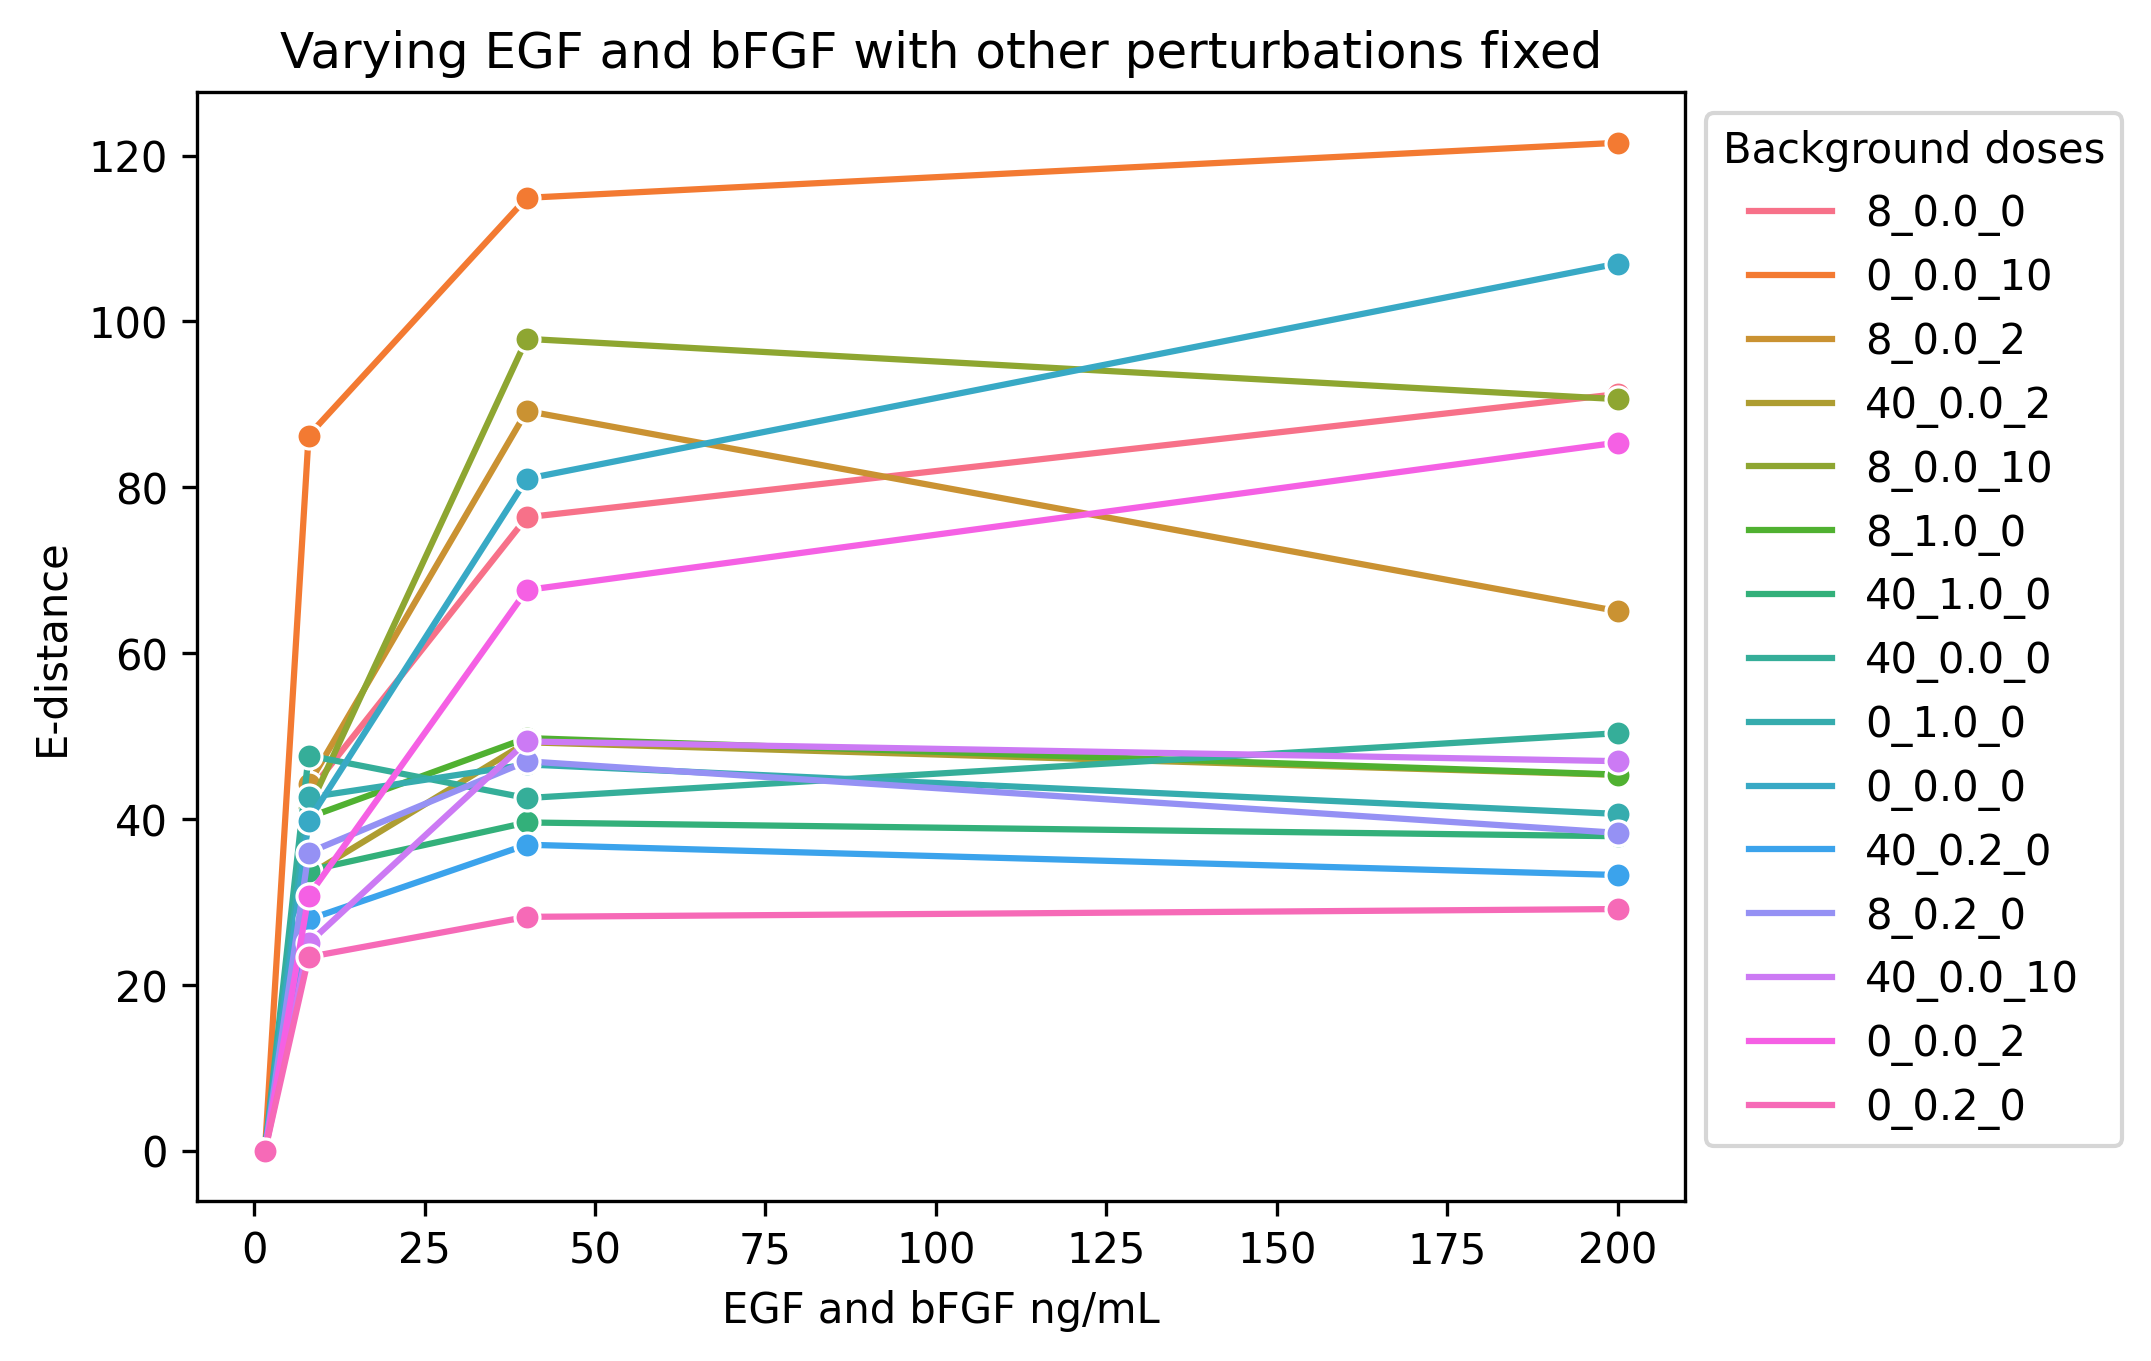

In [41]:

pert= 'p2'

a = plot_pairs(estats, pert)
ax = sns.lineplot(x = pert+'_y',  y = 'value' , data = a , hue= 'temp', marker="o")#, legend=None)
plt.legend(title='Background doses')
plt.title("Varying EGF and bFGF with other perturbations fixed")
plt.xlabel("EGF and bFGF ng/mL")
plt.ylabel("E-distance")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("Gehring_Pachter_EGF_bFGF.pdf", bbox_inches="tight")

In [44]:
adata.obs['dose_unit_3']

AAACCTGCACACATGT    uM
AAACCTGCACGTCAGC    uM
AAACCTGCATTGGTAC    uM
AAACCTGGTCGCATAT    uM
AAACCTGGTGCAGGTA    uM
                    ..
TTTGGTTAGGAACTGC    uM
TTTGGTTGTCCAGTAT    uM
TTTGTCAAGCCACTAT    uM
TTTGTCAGTCCAAGTT    uM
TTTGTCATCGGTGTCG    uM
Name: dose_unit_3, Length: 20382, dtype: category
Categories (1, object): ['uM']

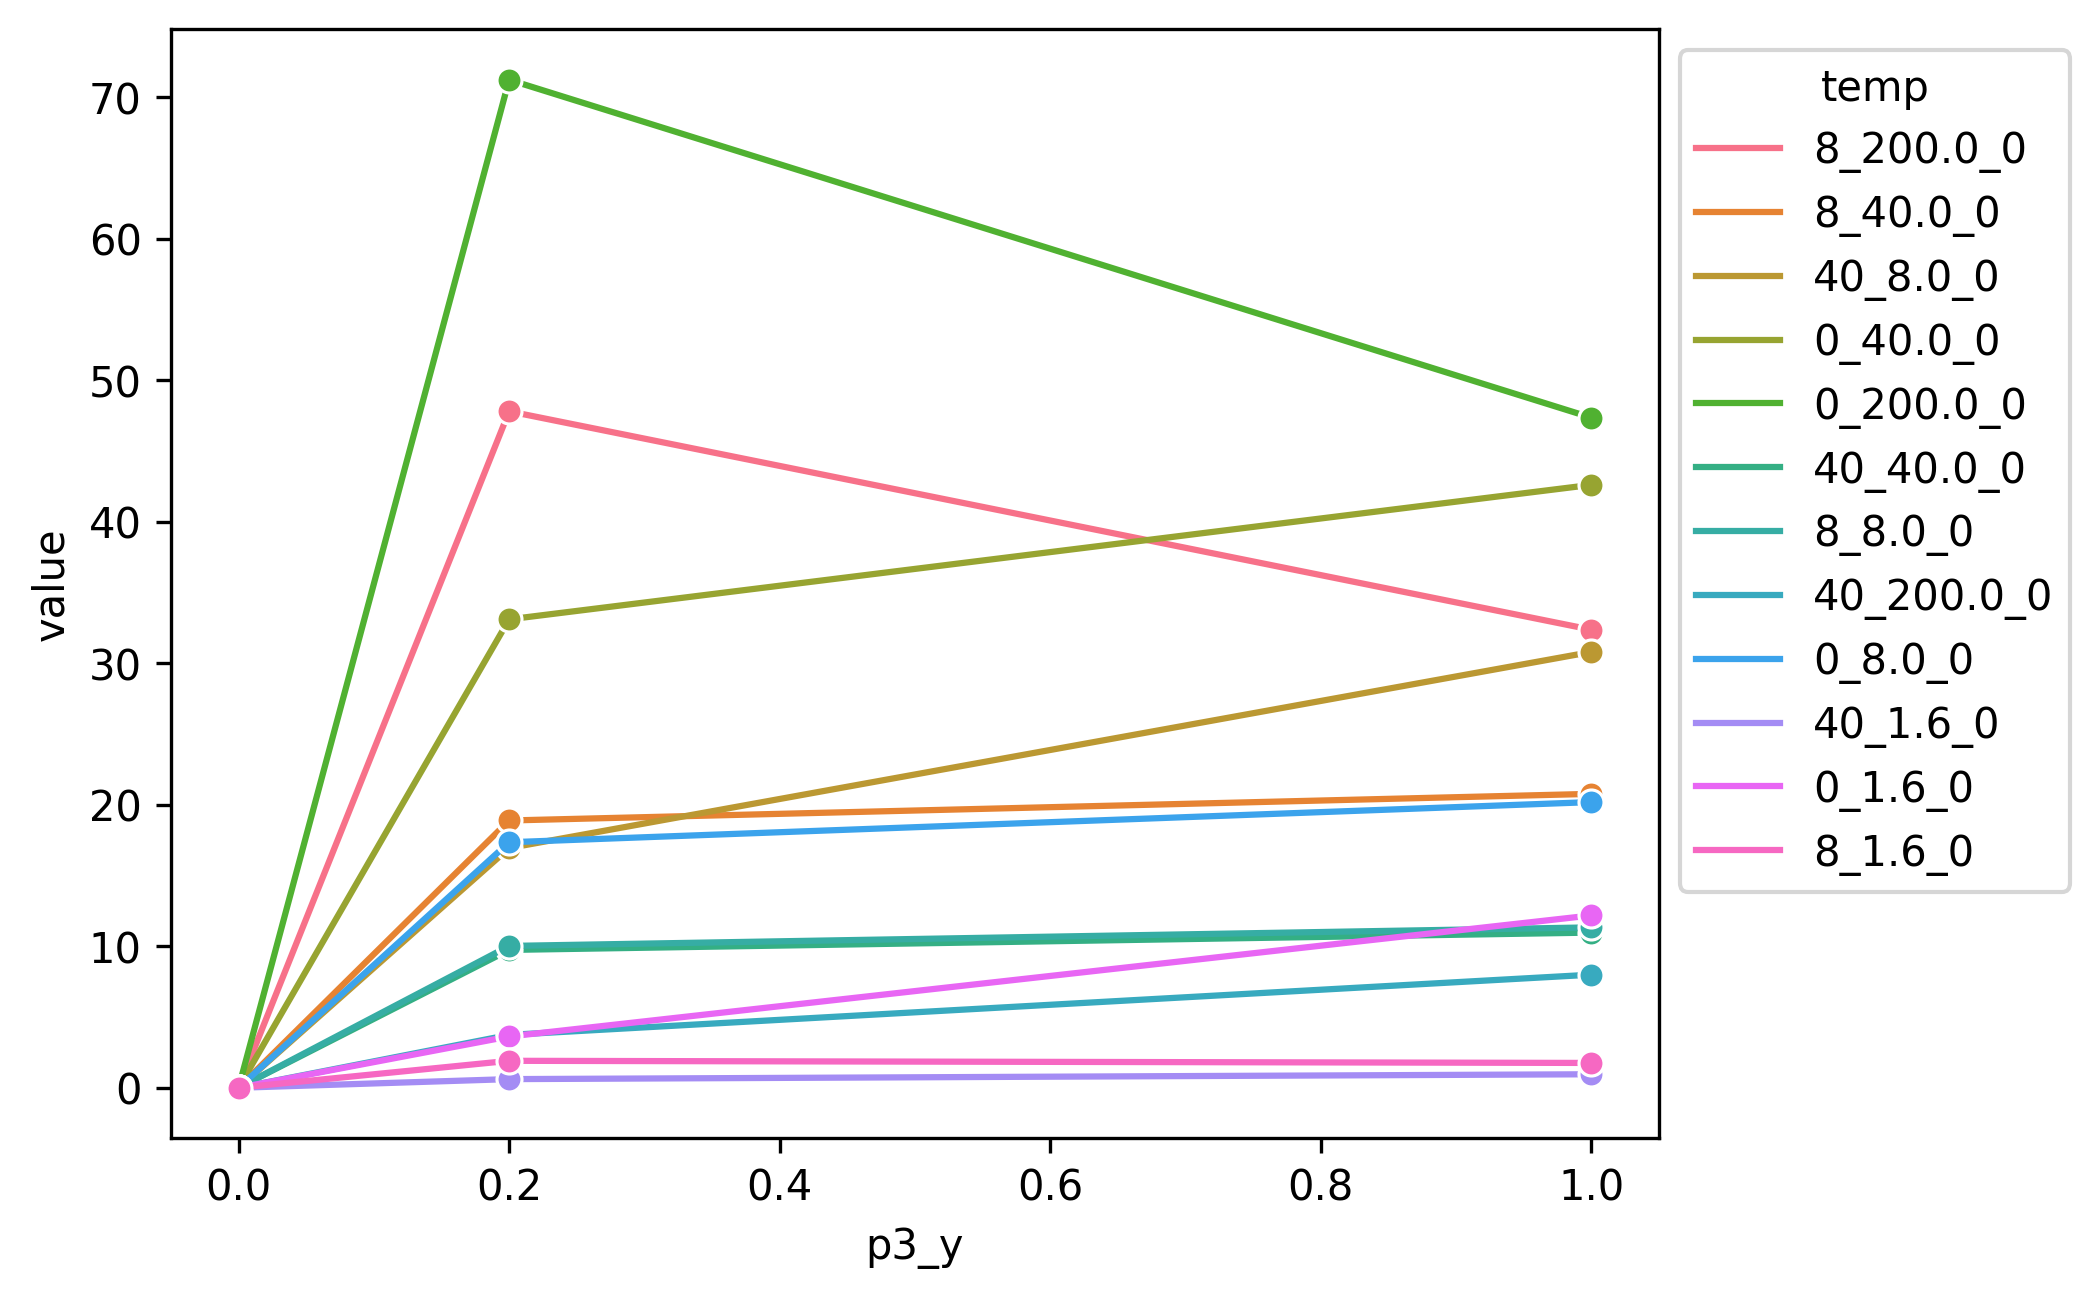

In [15]:

pert= 'p3'

a = plot_pairs(estats, pert)
ax = sns.lineplot(x = pert+'_y',  y = 'value' , data = a , hue= 'temp', marker="o")#, legend=None)
#plt.legend(loc='upper right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

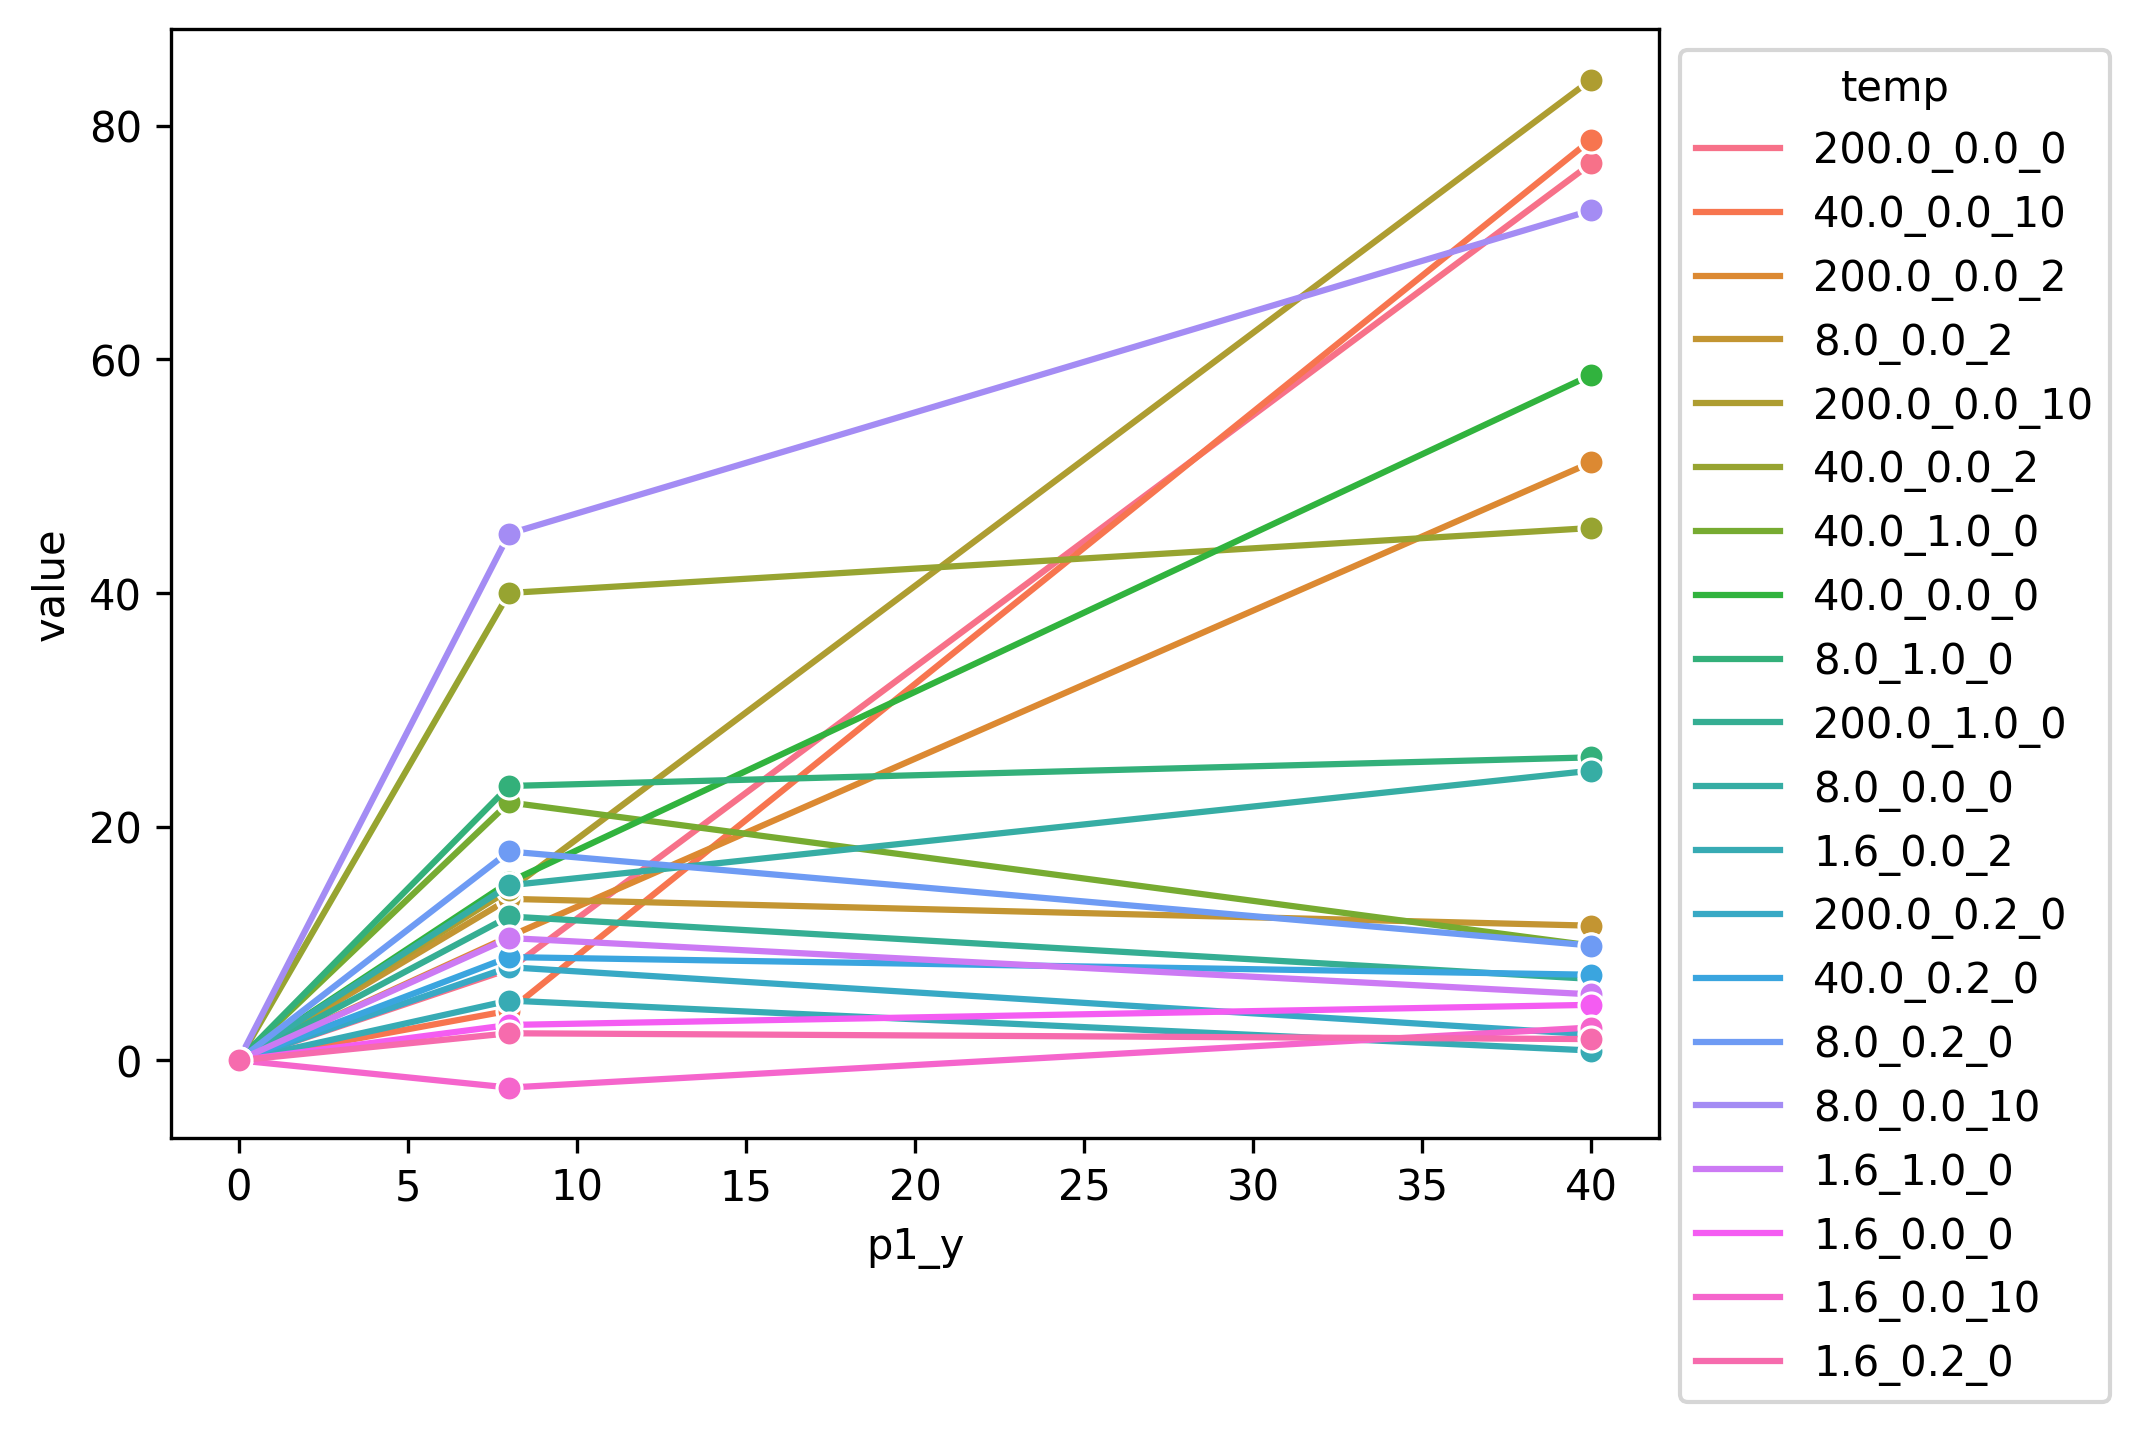

In [16]:

pert= 'p1'

a = plot_pairs(estats, pert)
ax = sns.lineplot(x = pert+'_y',  y = 'value' , data = a , hue= 'temp', marker="o")#, legend=None)
#plt.legend(loc='upper right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

 32%|████████████▋                           | 316/1000 [25:31<55:14,  4.85s/it]


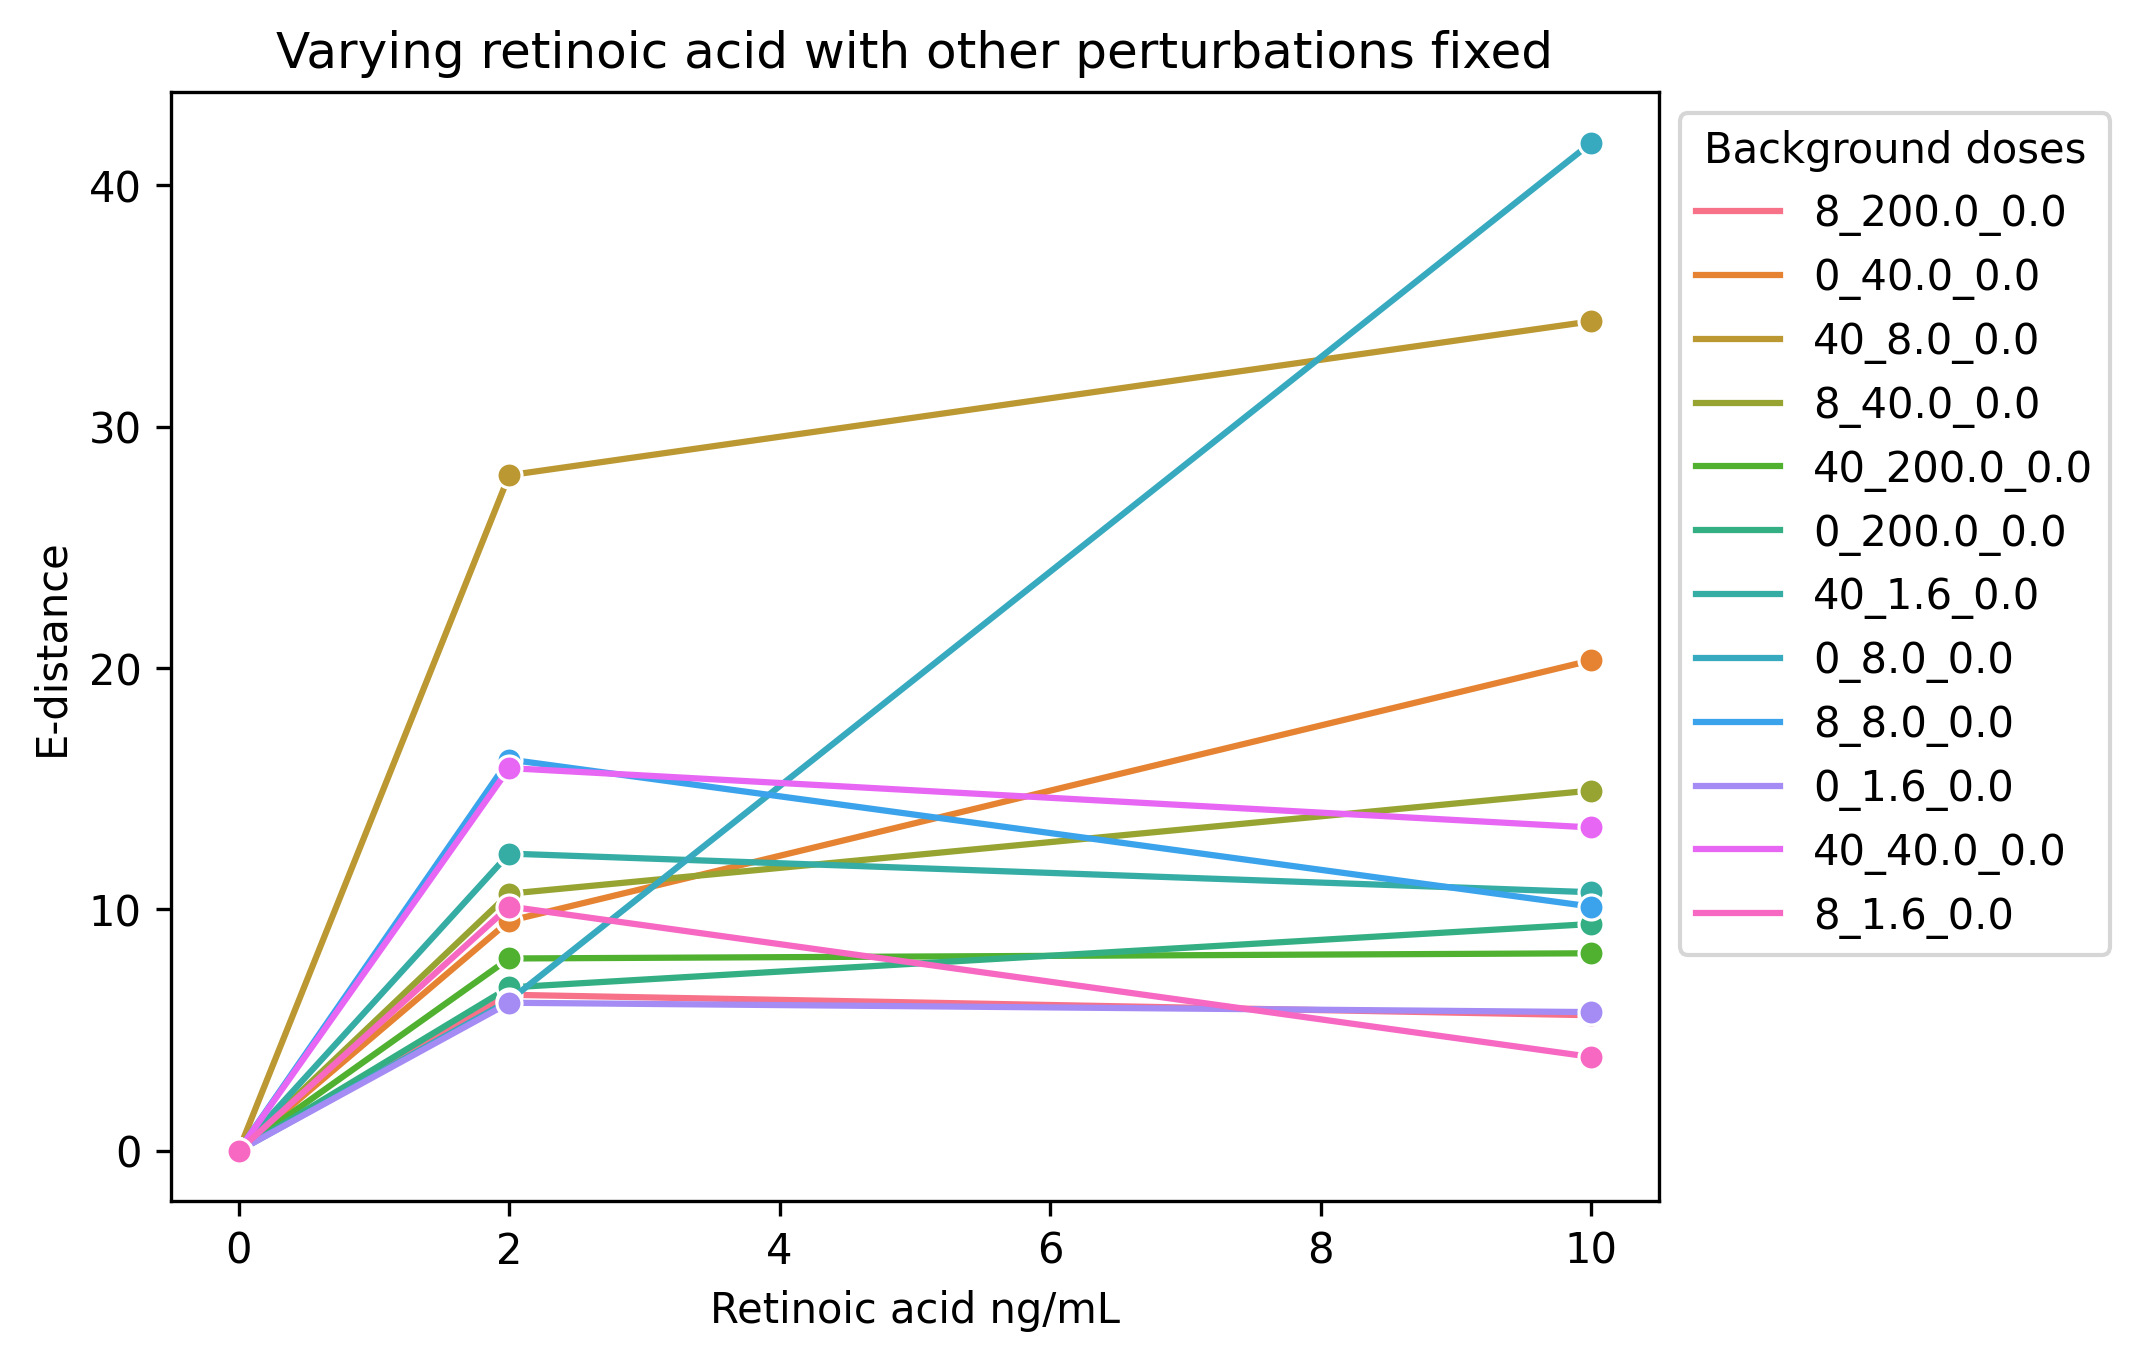

In [40]:

pert= 'p4'

a = plot_pairs(estats, pert)
ax = sns.lineplot(x = pert+'_y',  y = 'value' , data = a , hue= 'temp', marker="o", legend="brief")
plt.legend(title='Background doses')

plt.title("Varying retinoic acid with other perturbations fixed")
plt.xlabel("Retinoic acid ng/mL")
plt.ylabel("E-distance")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("Gehring_Pachter_RA.pdf", bbox_inches="tight")

In [172]:
a[a['p4_y']==10].sort_values('value')

,perturbation_x,perturbation_y,value,p1_x,p2_x,p3_x,p4_x,p1_y,p2_y,p3_y,p4_y,temp,temp_2
360,p1_8_p2_200.0_p3_0.0_p4_0,p1_8_p2_200.0_p3_0.0_p4_10,0.422665,8,200.0,0.0,0,8,200.0,0.0,10.0,8_200.0_0.0,8_200.0_0.0
496,p1_0_p2_200.0_p3_0.0_p4_0,p1_0_p2_200.0_p3_0.0_p4_10,0.808656,0,200.0,0.0,0,0,200.0,0.0,10.0,0_200.0_0.0,0_200.0_0.0
2021,p1_40_p2_200.0_p3_0.0_p4_0,p1_40_p2_200.0_p3_0.0_p4_10,0.944479,40,200.0,0.0,0,40,200.0,0.0,10.0,40_200.0_0.0,40_200.0_0.0
2855,p1_0_p2_1.6_p3_0.0_p4_0,p1_0_p2_1.6_p3_0.0_p4_10,1.004733,0,1.6,0.0,0,0,1.6,0.0,10.0,0_1.6_0.0,0_1.6_0.0
250,p1_8_p2_40.0_p3_0.0_p4_0,p1_8_p2_40.0_p3_0.0_p4_10,1.076451,8,40.0,0.0,0,8,40.0,0.0,10.0,8_40.0_0.0,8_40.0_0.0
3454,p1_8_p2_8.0_p3_0.0_p4_0,p1_8_p2_8.0_p3_0.0_p4_10,1.176003,8,8.0,0.0,0,8,8.0,0.0,10.0,8_8.0_0.0,8_8.0_0.0
2439,p1_40_p2_40.0_p3_0.0_p4_0,p1_40_p2_40.0_p3_0.0_p4_10,1.266408,40,40.0,0.0,0,40,40.0,0.0,10.0,40_40.0_0.0,40_40.0_0.0
2638,p1_8_p2_1.6_p3_0.0_p4_0,p1_8_p2_1.6_p3_0.0_p4_10,1.281199,8,1.6,0.0,0,8,1.6,0.0,10.0,8_1.6_0.0,8_1.6_0.0
86,p1_0_p2_40.0_p3_0.0_p4_0,p1_0_p2_40.0_p3_0.0_p4_10,1.386548,0,40.0,0.0,0,0,40.0,0.0,10.0,0_40.0_0.0,0_40.0_0.0
1453,p1_40_p2_8.0_p3_0.0_p4_0,p1_40_p2_8.0_p3_0.0_p4_10,2.573227,40,8.0,0.0,0,40,8.0,0.0,10.0,40_8.0_0.0,40_8.0_0.0


In [177]:
adata.obs['dose_value_4'].unique()

array([ 0, 10,  2])

In [179]:
adata.obs['dose_value_2'].unique()

array([200. ,  40. ,   8. ,   1.6])

In [190]:
adata.obs['perturbation_4'].unique()

['retinoic acid']
Categories (1, object): ['retinoic acid']

 Gehring et al state "Absence of EGF and bFGF has a drastic effect, yielding an isolated group of samples in PCA space, while BMP4 concentration has a graded effect and a strong interaction with retinoic acid, producing low BMP4, high BMP4, and BMP4 and retinoic acid cell states."
 
While these states are different from each other, they aren't necessarily more different from the no EGF/bFGF state 

The unusual state in terms of retinoic acid effect has no BMP4, low EGF & bFGF, and no 1:5 scriptaid:decitabine. This case is flagged in Fig 2c of that paper, and the authors note a "strong condition dependence". This condition dependence is explored in more detail in the original work, including cluster analysis and differential gene expression. Here, E-distance analysis reveals the same condition dependence.


In [187]:
df.to_csv("GehringPachter_distances_no_sigs.csv")

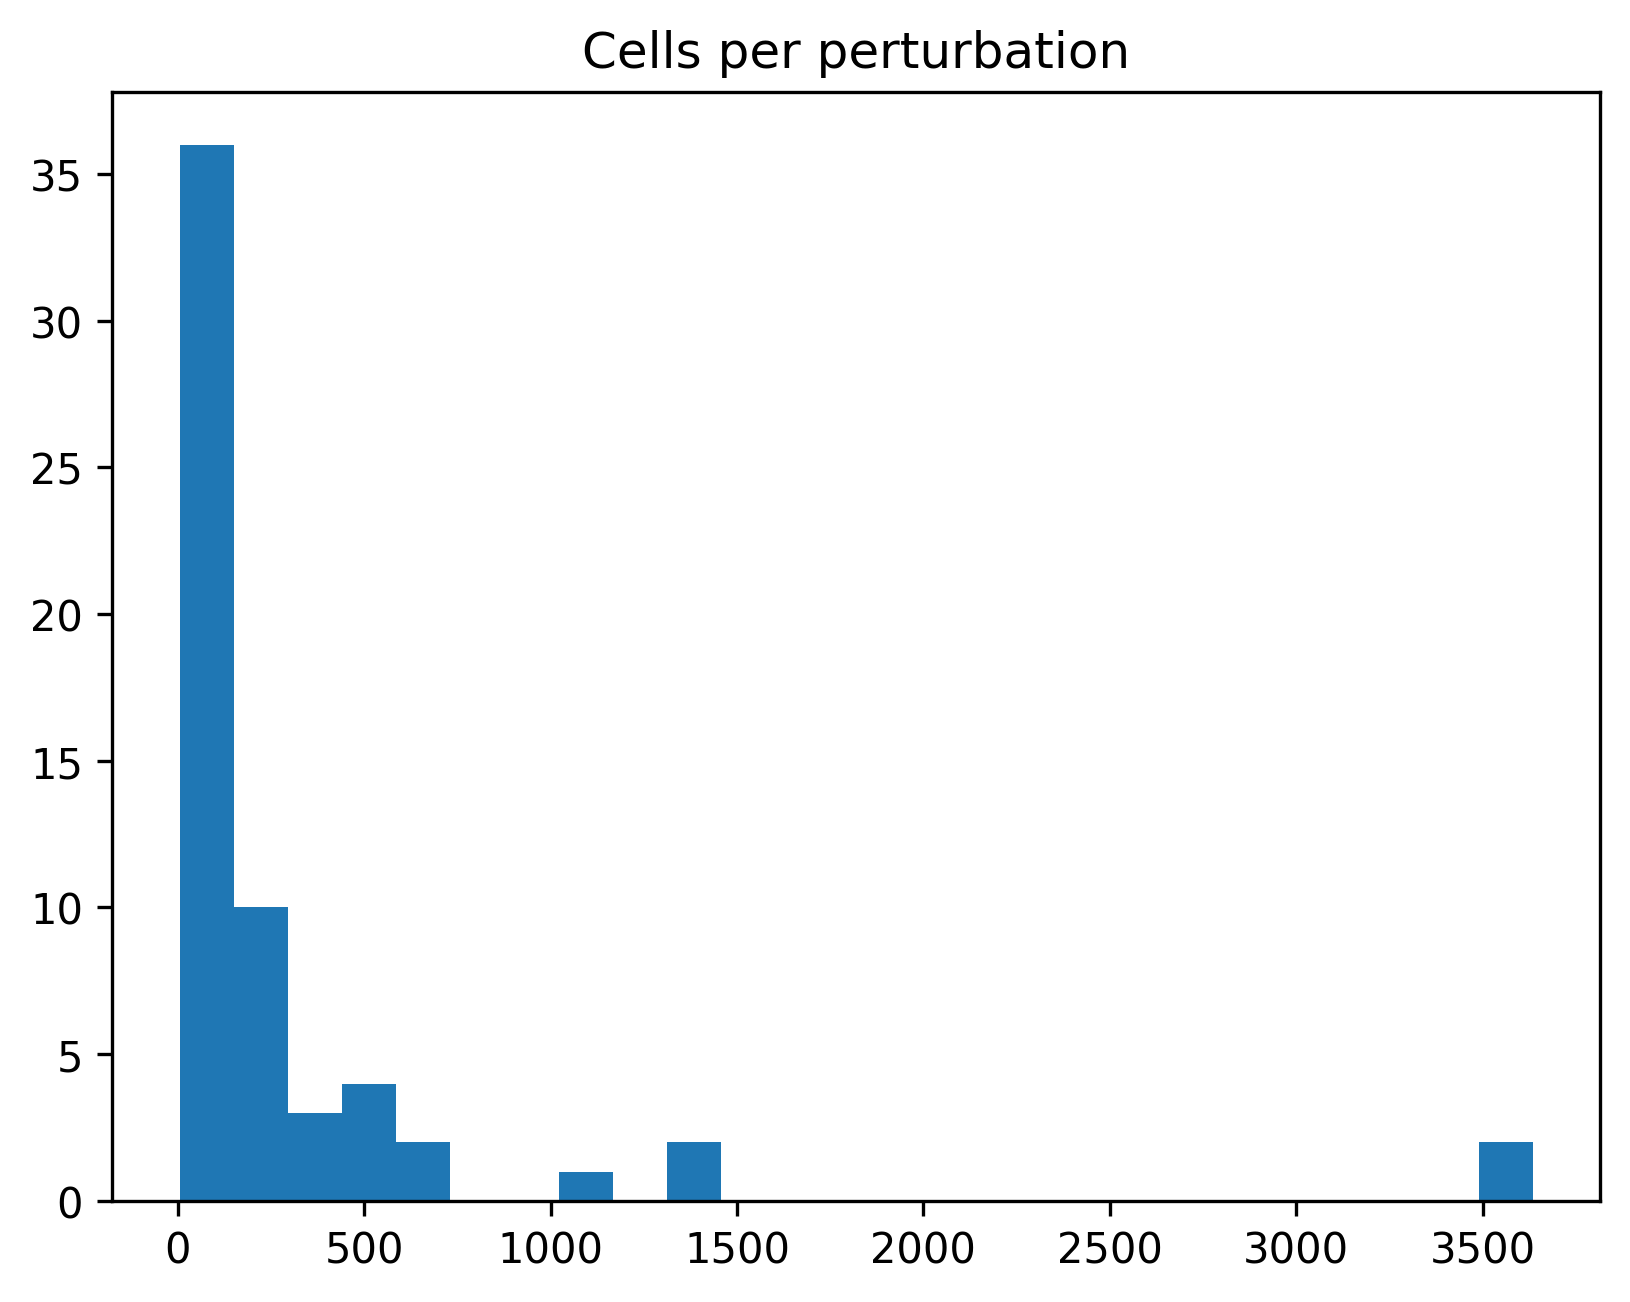

In [65]:
plt.hist(adata.obs['perturbation'].value_counts().values,bins=25)
plt.title("Cells per perturbation")
plt.savefig("GehringPachter_hist.pdf")
#plt.xlabel("Retinoic acid ng/mL")
#plt.ylabel("E-distance")

In [61]:
adata.obs['perturbation'].value_counts().values

array([3634, 3627, 1433, 1397, 1157,  685,  632,  565,  531,  506,  489,
        377,  330,  325,  291,  258,  257,  209,  209,  205,  204,  198,
        182,  176,  150,  148,  147,  135,  132,  129,  123,  116,  113,
        109,  108,  104,  101,   93,   73,   72,   72,   70,   63,   56,
         50,   40,   38,   36,   36,   31,   29,   26,   25,   23,   16,
         11,    9,    8,    7,    6])